<a href="https://colab.research.google.com/github/resfy/Allure.id/blob/main/Machine%20Learning/threads_classification_DNN_2Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import nltk
import string
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
stopwords = nltk.corpus.stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def text_process(text):
    pattern = r'</*\w+[\w:/."= ]*>'
    text = re.sub(pattern, '', text)
    text = text.translate(str.maketrans(" ", " ", string.punctuation))
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

def make_prediction(model, input_data):
    predict_dict = {0: 'High Quality', 1: 'Low Quality'}
    prediction = model.predict(input_data)
    prediction = predict_dict[round(prediction[0, 0])]
    return prediction


In [ ]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')

In [ ]:
train_data.head(n = 10)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
5,34554026,Accessing pointer member of the structure usin...,<p>I have defined integer pointer inside the s...,<c><pointers><data-structures>,2016-01-01 06:21:17,LQ_CLOSE
6,34554206,"How To Disable 2nd Saturday 4th Saturday ,Sund...","i want to Disable 2nd Saturday 4th saturday,...",<javascript><jquery><jquery-ui>,2016-01-01 06:55:18,LQ_EDIT
7,34554671,Resizing containers in bootstrap,I am new to bootstrap and i would like to find...,<jquery><html><css><twitter-bootstrap>,2016-01-01 08:32:05,LQ_EDIT
8,34554871,Changing Theme in Windows 10 UWP App Programma...,<p>I was able to change theme using <code>this...,<c#><windows-10><windows-10-mobile><windows-10...,2016-01-01 09:05:45,HQ
9,34554982,TextBox Value Disappears VB6,I my case I am having two form Form 1 and Form...,<vb6>,2016-01-01 09:27:44,LQ_EDIT


In [ ]:
valid_data.head(n = 10)

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
5,34557209,How do I make a constructor for a derived class?,<p>I am trying to make a constructor for a der...,<c++><inheritance><constructor><derived-class>,2016-01-01 14:58:52,LQ_CLOSE
6,34557363,how can i create a dynamic tow dimensional arr...,I am using c++ in my lesson and for solving a...,<c++>,2016-01-01 15:21:17,LQ_EDIT
7,34557587,Re-exporting ES6 modules in TS 1.7?,<p>I'm getting a bit lost in TS re-exports. Sa...,<typescript><ecmascript-6><es6-module-loader><...,2016-01-01 15:50:30,HQ
8,34558264,Fetch API with Cookie,<p>I am trying out the new Fetch API but is ha...,<cookies><fetch-api>,2016-01-01 17:21:19,HQ
9,34559136,Print list content in a given order,"<pre><code>lt = ['7,777.7', '777.7', '77,777.7...",<python><list><python-2.7><for-loop>,2016-01-01 19:08:12,LQ_CLOSE


In [ ]:
def change_labels(label):
    if label == 'HQ':
        return 0
    else:
        return 1

In [ ]:
train_data['Text'] = train_data['Title'] + ' ' + train_data['Body']
valid_data['Text'] = valid_data['Title'] + ' ' + valid_data['Body']
train_data['Labels'] = train_data['Y'].apply(change_labels)
valid_data['Labels'] = valid_data['Y'].apply(change_labels)
train_data.drop(columns = ['Id', 'Tags', 'CreationDate'], inplace = True)
valid_data.drop(columns = ['Id', 'Tags', 'CreationDate'], inplace = True)
train_data.head(n = 10)

,Title,Body,Y,Text,Labels
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,LQ_CLOSE,Java: Repeat Task Every Random Seconds <p>I'm ...,1
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,HQ,Why are Java Optionals immutable? <p>I'd like ...,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,HQ,Text Overlay Image with Darkened Opacity React...,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",HQ,Why ternary operator in swift is so picky? <p>...,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,HQ,hide/show fab with scale animation <p>I'm usin...,0
5,Accessing pointer member of the structure usin...,<p>I have defined integer pointer inside the s...,LQ_CLOSE,Accessing pointer member of the structure usin...,1
6,"How To Disable 2nd Saturday 4th Saturday ,Sund...","i want to Disable 2nd Saturday 4th saturday,...",LQ_EDIT,"How To Disable 2nd Saturday 4th Saturday ,Sund...",1
7,Resizing containers in bootstrap,I am new to bootstrap and i would like to find...,LQ_EDIT,Resizing containers in bootstrap I am new to b...,1
8,Changing Theme in Windows 10 UWP App Programma...,<p>I was able to change theme using <code>this...,HQ,Changing Theme in Windows 10 UWP App Programma...,0
9,TextBox Value Disappears VB6,I my case I am having two form Form 1 and Form...,LQ_EDIT,TextBox Value Disappears VB6 I my case I am ha...,1


In [ ]:
clean_text = train_data['Text'].apply(text_process)
clean_text

0        java repeat task every random seconds im alrea...
1        java optionals immutable id like understand ja...
2        text overlay image darkened opacity react nati...
3        ternary operator swift picky question simple c...
4        hideshow fab scale animation im using custom f...
                               ...                        
44995    convert list string c aspnet sql server new as...
44996    python execute code top bottom script working ...
44997    change payment date azure looks like costs 8 d...
44998    implement fill blank swift questions want impl...
44999    make c application outside visual studio im ne...
Name: Text, Length: 45000, dtype: object

In [ ]:
valid_clean_text = valid_data['Text'].apply(text_process)
valid_clean_text

0        get child records different tables based given...
1        retrieve except data another table two table m...
2        pandas readhtml im trying extract us states wi...
3        reader always gimme null im new c wanna make a...
4        php rearrange array elements based condition b...
                               ...                        
14995    align two flex boxes follow menu id like divri...
14996    c correct way multiply integer double try mult...
14997    django showing error try open new page hyperli...
14998    php getting content php page controller inside...
14999    cant overloaded functions vary return type rec...
Name: Text, Length: 15000, dtype: object

In [ ]:
vectorizer = TfidfVectorizer('english')
features = vectorizer.fit_transform(clean_text)

In [ ]:
labels = train_data['Labels'].values
validation_features = vectorizer.transform(valid_clean_text)
validation_labels = valid_data['Labels'].values

In [ ]:
features.sort_indices()
validation_features.sort_indices()

In [ ]:
features.shape

(45000, 387505)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 128, input_shape = (features.shape[1],), activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics = ['accuracy'])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = os.getcwd(), monitor = 'val_accuracy',
                                                      verbose = 1, save_best_only = True,
                                                      save_weights_only = True)
history = model.fit(features, labels, epochs = 5, batch_size = 16, callbacks = [model_checkpoint],
                    validation_data = (validation_features, validation_labels))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


2813/2813 [==============================] - 1350s 479ms/step - loss: 0.4937 - accuracy: 0.7722 - val_loss: 0.3575 - val_accuracy: 0.8550

Epoch 00001: val_accuracy improved from -inf to 0.85500, saving model to /content
Epoch 2/5
2813/2813 [==============================] - 1392s 495ms/step - loss: 0.3006 - accuracy: 0.8842 - val_loss: 0.3086 - val_accuracy: 0.8707

Epoch 00002: val_accuracy improved from 0.85500 to 0.87067, saving model to /content
Epoch 3/5
2813/2813 [==============================] - 1407s 500ms/step - loss: 0.2296 - accuracy: 0.9139 - val_loss: 0.2973 - val_accuracy: 0.8759

Epoch 00003: val_accuracy improved from 0.87067 to 0.87593, saving model to /content
Epoch 4/5
2813/2813 [==============================] - 1409s 501ms/step - loss: 0.1834 - accuracy: 0.9338 - val_loss: 0.2967 - val_accuracy: 0.8771

Epoch 00004: val_accuracy improved from 0.87593 to 0.87713, saving model to /content
Epoch 5/5
2813/2813 [==============================] - 1407s 500ms/step - los

In [ ]:
with open('tfidf_vectorizer.pkl', 'wb') as output_file:
    pickle.dump(vectorizer, output_file)

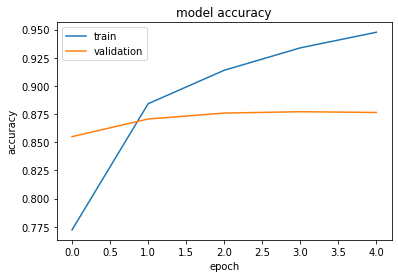

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save('rekomendasi_thread.h5')